## Se tortille ou non classifieur

**But :** Réaliser un CNN qui prédit si un vers se tortille ou non

Organisation :
* data augmentation car déficite sur le oui
* classification binaire *oui* ou *non*

### Import

In [1]:
from os import listdir

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

import torchvision
from torchvision.io import read_image
from torchvision import transforms as T
from torchvision.io import read_image

from torch.utils.tensorboard import SummaryWriter

import skimage.transform

import time
import copy

/media/HDD/planaire_classification/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Prétraitement datasets

In [42]:
data_dir = "../data/images_croped_color/tortille_dataset"

In [43]:
def get_dataset_infos(path, nb_frames=4):
    
    def get_key(elem):
        return float(elem[:elem.index('.jpg')])

    class_path = listdir(path)
    data = []
    labels = []
    for c in class_path:
        videos_path = listdir(f"{path}/{c}")
        for v in videos_path :
            imgs = listdir(f"{path}/{c}/{v}")
            imgs.sort(key=get_key)

            for i in range(len(imgs)):
                temp = imgs[i:i+nb_frames]      
                if len(temp)%nb_frames == 0:
                    #frames = [read_image(f"{path}/{c}/{v}/{i}") for i in temp]
                    frames = [f"{path}/{c}/{v}/{i}" for i in temp]
                    data.append(frames) 
                    #data.append(temp) 
                    labels.append(int(c))
    
    return data, labels

In [44]:
nb_frames = 5

videos_frames_train, labels_train = get_dataset_infos(f"{data_dir}/train", nb_frames=nb_frames)
videos_frames_val, labels_val = get_dataset_infos(f"{data_dir}/val", nb_frames=nb_frames)

In [45]:
videos_frames_val[:2]

[['../data/images_croped_color/tortille_dataset/val/1/168/9.jpg',
  '../data/images_croped_color/tortille_dataset/val/1/168/10.jpg',
  '../data/images_croped_color/tortille_dataset/val/1/168/11.jpg',
  '../data/images_croped_color/tortille_dataset/val/1/168/12.jpg',
  '../data/images_croped_color/tortille_dataset/val/1/168/13.jpg'],
 ['../data/images_croped_color/tortille_dataset/val/1/166/1.jpg',
  '../data/images_croped_color/tortille_dataset/val/1/166/2.jpg',
  '../data/images_croped_color/tortille_dataset/val/1/166/3.jpg',
  '../data/images_croped_color/tortille_dataset/val/1/166/4.jpg',
  '../data/images_croped_color/tortille_dataset/val/1/166/5.jpg']]

### Calcul std et mean

In [2]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, path, transform=None):
        self.data = [f"{path}/{i}" for i in listdir(path)]
        self.transform =transform
        
    def __getitem__(self, index):
        x = read_image(self.data[index])
        if self.transform:
                x = self.transform(x)
        return x

    def __len__(self):
        return len(self.data)

In [3]:
transform = T.Compose([T.ConvertImageDtype(dtype=torch.float32)])

#dataset = MyDataset("../data/images_croped_color/all",transform=transform)
dataset = MyDataset("../data/images/all",transform=transform)
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=10,
    shuffle=False
)

In [4]:
mean = 0.
std = 0.
nb_samples = 0.
for data in loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

In [5]:
mean,std

(tensor([0.6248, 0.5959, 0.5339]), tensor([0.1259, 0.1148, 0.1080]))

In [46]:
mean  = [0.6837, 0.6463, 0.5815]
std = [0.1203, 0.1112, 0.1055]

## Création du Dataset

In [47]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, videos_frames, labels, device='cpu', transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.videos = videos_frames
        self.labels = labels
    
    def __getitem__(self, index):
        
        frames = []
        label = torch.tensor(self.labels[index], dtype=torch.long).to(device)
        
        #print(self.videos[index])
        for f in self.videos[index]:
            frame = read_image(f)
            if self.transform:
                frame = self.transform(frame).to(device)
            frames.append(frame)

        return torch.stack(frames), label
        
    def __len__(self):
        return len(self.videos)

In [48]:
transform = T.Compose([
                        #T.Resize((224,224)),
                        T.ConvertImageDtype(dtype=torch.float32),
                        T.Normalize(mean=mean, std=std)])

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [50]:
dataset_train = ImageDataset(videos_frames_train, labels_train, device=device, transform=transform)
dataset_val = ImageDataset(videos_frames_val, labels_val, device=device, transform=transform)

dataset_sizes = {'train':len(videos_frames_train),
                 'val':len(videos_frames_val)}

dataset_sizes

{'train': 1621, 'val': 760}

In [51]:
batch_size = 16

train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

dataloaders = {'train':train_dataloader,
                'val':val_dataloader}

In [12]:
imgs, labs = next(iter(val_dataloader))
print(imgs.size(), labs)

torch.Size([16, 5, 3, 224, 224]) tensor([0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')


In [16]:
grid = torchvision.utils.make_grid(imgs[1])

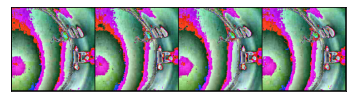

In [17]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(grid)

### CNN

## Custom model

In [39]:
class CNNLSTM(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNLSTM, self).__init__()
        self.resnet = torchvision.models.resnet101(pretrained=True)
        self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, 300))
        self.lstm = nn.LSTM(input_size=300, hidden_size=256, num_layers=3)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)
       
    def forward(self, x_3d):
        hidden = None
        for t in range(x_3d.size(1)):
            with torch.no_grad():
                x = self.resnet(x_3d[:, t, :, :, :])  
            out, hidden = self.lstm(x.unsqueeze(0), hidden)         

        x = self.fc1(out[-1, :, :])
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [52]:
class CNNLSTM(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=8,
                               kernel_size=3)
        self.bn1 = nn.BatchNorm2d(8) # nb de channels out

        self.conv2 = nn.Conv2d(in_channels=8,
                               out_channels=16,
                               kernel_size=3)
        self.bn2 = nn.BatchNorm2d(16) # nb de channels out
        
        self.conv3 = nn.Conv2d(in_channels=16,
                               out_channels=32,
                               kernel_size=3)
        self.bn3 = nn.BatchNorm2d(32) # nb de channels out
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.dropout = nn.Dropout()

        self.out_cnn = nn.Linear(56448, 500)

        self.lstm = nn.LSTM(input_size=500, hidden_size=256, num_layers=3)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)
       
    def forward(self, x_3d):
        hidden = None
        for t in range(x_3d.size(1)):
            with torch.no_grad():
                x = self.pool(self.bn1(F.relu(self.conv1(x_3d[:, t, :, :, :]))))
                
                x = self.pool(self.bn2(F.relu(self.conv2(x))))
                
                x = self.pool(self.bn3(F.relu(self.conv3(x))))
                


                x = x.view(-1, 56448) # flatten
                #x = torch.flatten(x)
                x = F.relu(self.out_cnn(self.dropout(x)))

            out, hidden = self.lstm(x.unsqueeze(0), hidden)         

        x = self.fc1(out[-1, :, :])
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [13]:
from utils import AverageMeter, calculate_accuracy
import random

def train_epoch(model, data_loader, criterion, optimizer, epoch, log_interval, device):
    model.train()
 
    train_loss = 0.0
    losses = AverageMeter()
    accuracies = AverageMeter()
    for batch_idx, (data, targets) in enumerate(data_loader):
        data, targets = data.to(device), targets.to(device)
        outputs = model(data.float())
        loss = criterion(outputs, targets)
        acc = calculate_accuracy(outputs, targets)

        train_loss += loss.item()
        losses.update(loss.item(), data.size(0))
        accuracies.update(acc, data.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % log_interval == 0:
            avg_loss = train_loss / log_interval
            # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #     epoch, (batch_idx + 1) * len(data), len(data_loader.dataset), 100. * (batch_idx + 1) / len(data_loader), avg_loss))
            # train_loss = 0.0

    print('Train set ({:d} samples): Average loss: {:.4f}\tAcc: {:.4f}%'.format(
        len(data_loader.dataset), losses.avg, accuracies.avg * 100))

    return losses.avg, accuracies.avg


def val_epoch(model, data_loader, criterion, device):
    model.eval()

    losses = AverageMeter()
    accuracies = AverageMeter()
    with torch.no_grad():
        for (data, targets) in data_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data.float())  

            loss = criterion(outputs, targets)
            acc = calculate_accuracy(outputs, targets)

            losses.update(loss.item(), data.size(0))
            accuracies.update(acc, data.size(0))

    # show info
    print('Validation set ({:d} samples): Average loss: {:.4f}\tAcc: {:.4f}%'.format(len(data_loader.dataset), losses.avg, accuracies.avg * 100))
    return losses.avg, accuracies.avg


In [30]:
def train(model, dataloaders):
	train_loader, val_loader = (dataloaders['train'], dataloaders['val'])

	crnn_params = list(model.parameters())
	optimizer = torch.optim.Adam(crnn_params, lr=1e-3, weight_decay=1e-3)
	# scheduler = lr_scheduler.ReduceLROnPlateau(
	# 	optimizer, 'min', patience=opt.lr_patience)
	criterion = nn.CrossEntropyLoss()

	# tensorboard
	summary_writer = SummaryWriter(log_dir='tf_logs_custom')

	n_epochs = 15
	# start training
	for epoch in range(n_epochs):
		print('Epoch {}/{}'.format(epoch, n_epochs - 1))
		print('-' * 10)
		train_loss, train_acc = train_epoch(
			model, train_loader, criterion, optimizer, epoch, 10, device)
		val_loss, val_acc = val_epoch(
			model, val_loader, criterion, device)
		# saving weights to checkpoint
		if (epoch) % 2 == 0 or epoch == n_epochs - 1:
			# scheduler.step(val_loss)
			# write summary
			summary_writer.add_scalar(
				'losses/train_loss', train_loss, global_step=epoch)
			summary_writer.add_scalar(
				'losses/val_loss', val_loss, global_step=epoch)
			summary_writer.add_scalar(
				'acc/train_acc', train_acc * 100, global_step=epoch)
			summary_writer.add_scalar(
				'acc/val_acc', val_acc * 100, global_step=epoch)
			state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}
			# torch.save(state, os.path.join('snapshots', f'cnnlstm-Epoch-{epoch}-Loss-{val_loss}.pth'))
			# print("Epoch {} model saved!\n".format(epoch))

In [53]:
model = CNNLSTM().to(device)

In [54]:
out = train(model, dataloaders)

Epoch 0/14
----------
Train set (1621 samples): Average loss: 0.5007	Acc: 75.5706%
Validation set (760 samples): Average loss: 0.6441	Acc: 68.5526%
Epoch 1/14
----------
Train set (1621 samples): Average loss: 0.3126	Acc: 87.7236%
Validation set (760 samples): Average loss: 0.3621	Acc: 84.4737%
Epoch 2/14
----------
Train set (1621 samples): Average loss: 0.2423	Acc: 90.6231%
Validation set (760 samples): Average loss: 0.7763	Acc: 74.6053%
Epoch 3/14
----------
Train set (1621 samples): Average loss: 0.1882	Acc: 92.8439%
Validation set (760 samples): Average loss: 0.5514	Acc: 80.5263%
Epoch 4/14
----------
Train set (1621 samples): Average loss: 0.2066	Acc: 92.2270%
Validation set (760 samples): Average loss: 0.5291	Acc: 84.3421%
Epoch 5/14
----------
Train set (1621 samples): Average loss: 0.1292	Acc: 94.8180%
Validation set (760 samples): Average loss: 0.4331	Acc: 82.3684%
Epoch 6/14
----------
Train set (1621 samples): Average loss: 0.1091	Acc: 95.8667%
Validation set (760 samples):

### Analyse

|  Images | nb frames | intervale | précision |centrée|
| :---------------: |:---------------:| :-----:| :-----:| :-----:|
|640x470|4|1|84%|
|640x470|5|1|88%|
|350x350|4|1|90%|
|350x350|5|1|92%|
|350x350|5|||
|350x350|6|0.5|76%|

In [17]:
best_model_state = model.state_dict()
torch.save(best_model_state, f"../models/cnn_ltsm_croped_{nb_frames}.pt")

In [43]:
imgs, labs = next(iter(val_dataloader))
print(imgs.size(),labs)

torch.Size([1, 5, 3, 224, 224]) tensor([0], device='cuda:0')


In [15]:
model_dict = torch.load("../models/cnn_ltsm_croped_5.pt")

In [ ]:
model = CNNLSTM().to(device)
model.load_state_dict(model_dict)
model.eval()

In [45]:
model.eval()
predict = model(imgs)
predict

tensor([[ 4.0280, -3.8961]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [46]:
p = np.argmax(predict.cpu().detach().numpy())
p

0